# Preparing

In [1]:
# !nvidia-smi

## Install library

In [2]:
# !pip install --quiet pytorch-lightning==1.2.5
# !pip install --quiet tqdm==4.59.0

## Import libraries

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc, rcParams
import math

import pandas as pd
import numpy as np
import tqdm
print(tqdm.__version__)
from tqdm.notebook import tqdm
import pytorch_lightning as pl
print(pl.__version__)
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

4.61.2
1.2.5


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALLETE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALLETE))

rcParams['figure.figsize'] = 12, 8

tqdm.pandas()

In [5]:
pl.seed_everything(42)

Global seed set to 42


42

# Data

## Loading watch data

In [6]:
path = "Datasets\Price_chart_Tang\Rolex 126334\Combine_all.csv"
path = 'Datasets\Price_chart_Game\Rolex\Rolex 126334\price.csv'
# path = 'Datasets\Price_chart_Game\Audemars Piguet\Audemars Piguet 15400OR\price.csv'
watch = pd.read_csv(path)
watch['Date'] = pd.to_datetime(watch['Date'], dayfirst=True)
watch['Price'] = pd.to_numeric(watch['Price'])
watch.head()

,Date,Price
0,2019-03-08,8775
1,2019-03-10,8852
2,2019-03-14,8852
3,2019-03-17,8615
4,2019-03-20,8579


In [7]:
watch = watch.resample('D', on='Date', convention='s').mean()
watch['Date'] = watch.index
watch.reset_index(drop=True, inplace=True)

watch.fillna(method='ffill', inplace=True)

print(watch.shape)
watch.head()

(1095, 2)


,Price,Date
0,8775.0,2019-03-08
1,8775.0,2019-03-09
2,8852.0,2019-03-10
3,8852.0,2019-03-11
4,8852.0,2019-03-12


In [8]:
watch["Prev_Price"] = watch.shift(1)["Price"]
watch.head()
print(type(watch))

<class 'pandas.core.frame.DataFrame'>


In [9]:
watch["Price_Change"] = watch.progress_apply(
    lambda row: 0 if np.isnan(row["Prev_Price"]) else row["Price"] - row["Prev_Price"],
    axis = 1
)
watch.head()

  0%|          | 0/1095 [00:00<?, ?it/s]

,Price,Date,Prev_Price,Price_Change
0,8775.0,2019-03-08,NaN,0.0
1,8775.0,2019-03-09,8775.0,0.0
2,8852.0,2019-03-10,8775.0,77.0
3,8852.0,2019-03-11,8852.0,0.0
4,8852.0,2019-03-12,8852.0,0.0


## Loading other data

In [10]:
gold = pd.read_csv("Datasets/Related_data/Gold_price.csv")
gold['Value'] = gold['Value'].str.replace(',','')
gold['Date'] = pd.to_datetime(gold['Date'], dayfirst=True)
gold['Value'] = pd.to_numeric(gold['Value'])
mask = (gold.Date >= watch.iloc[0]['Date']) & (gold.Date <= watch.iloc[-1]['Date'])
gold = gold.loc[mask]

gold = gold.resample('D', on='Date', convention='s').mean()
gold.fillna(method='ffill', inplace=True)

print(gold.shape)
gold.head()

(1093, 1)


,Value
Date,
2019-03-08,1296.8
2019-03-09,1296.8
2019-03-10,1296.8
2019-03-11,1292.8
2019-03-12,1297.1


## Create feature df

In [11]:
rows = []

for _, row in tqdm(watch.iterrows(), total=watch.shape[0]):
    row_data = dict(
        day_of_week = row.Date.dayofweek,
        day_of_month = row.Date.day,
        week_of_year = row.Date.week,
        month = row.Date.month,
        price_change = row.Price_Change,
        price = row.Price
    )
    rows.append(row_data)

features_df = pd.DataFrame(rows)

  0%|          | 0/1095 [00:00<?, ?it/s]

In [12]:
print(features_df.shape)
features_df.head()

(1095, 6)


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,4,8,10,3,0.0,8775.0
1,5,9,10,3,0.0,8775.0
2,6,10,10,3,77.0,8852.0
3,0,11,11,3,0.0,8852.0
4,1,12,11,3,0.0,8852.0


## Set TRAIN_RATIO

In [13]:
TRAIN_RATIO = 0.8

train_size = int(len(features_df) * TRAIN_RATIO)
print(train_size)

876


In [14]:
train_df, test_df = features_df[:train_size], features_df[train_size:]
print(train_df.shape, test_df.shape)

(876, 6) (219, 6)


## Scaler

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# scale = pd.read_csv('checkpoints/scale.csv', index_col=0)
# scaler.min_, scaler.scale_ = list(scale.loc[:,'min']), list(scale.loc[:,'scale'])
scaler = scaler.fit(train_df)

In [17]:
train_df = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

In [18]:
test_df = pd.DataFrame(
    scaler.transform(test_df),
    # test_df,
    index=test_df.index,
    columns=test_df.columns
)

In [19]:
test_df.head()

,day_of_week,day_of_month,week_of_year,month,price_change,price
876,0.666667,1.000000,0.115385,0.090909,-0.772968,0.985431
877,1.000000,-1.000000,0.115385,0.272727,-0.769435,0.988445
878,-1.000000,-0.933333,0.153846,0.272727,-0.799470,0.974378
879,-0.666667,-0.866667,0.153846,0.272727,-0.767668,0.978397
880,-0.333333,-0.800000,0.153846,0.272727,-0.753534,0.990455


In [20]:
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, days_pred):

    sequences = []
    data_size = len(input_data)

    for i in tqdm(range(data_size - sequence_length - days_pred)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length + days_pred
        label = input_data.iloc[label_position][target_column]
        
        sequences.append((sequence, label))

    return sequences

## Set SEQUENCE_LENGTH and Created sequences

In [21]:
SEQUENCE_LENGTH = 30
DAYS_PREDICTION = 30

train_sequences = create_sequences(train_df, "price", SEQUENCE_LENGTH, DAYS_PREDICTION)
test_sequences = create_sequences(test_df, "price", SEQUENCE_LENGTH, DAYS_PREDICTION)

  0%|          | 0/816 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

In [22]:
print(f"Sequence shape: {train_sequences[0][0].shape}")
print(f"Train length: {len(train_sequences)}")
print(f"Test length: {len(test_sequences)}")
print(f"Test length: {train_sequences[0][1]}")
train_sequences[0][0].head()

Sequence shape: (30, 6)
Train length: 816
Test length: 159
Test length: -0.691032403918614


,day_of_week,day_of_month,week_of_year,month,price_change,price
0,0.333333,-0.533333,-0.653846,-0.636364,-0.774735,-0.901532
1,0.666667,-0.466667,-0.653846,-0.636364,-0.774735,-0.901532
2,1.000000,-0.400000,-0.653846,-0.636364,-0.706714,-0.862849
3,-1.000000,-0.333333,-0.615385,-0.636364,-0.774735,-0.862849
4,-0.666667,-0.266667,-0.615385,-0.636364,-0.774735,-0.862849


# Classes create

## Set device

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print("configured device:", device)

configured device: cuda


## TS_Dataset (Time series)

In [24]:
class TS_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()).to(device),
            label = torch.tensor(label).float().to(device)
        )

## Price Data Module

In [25]:
class PriceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=8):
        super().__init__
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size
        
    def prepare_data(self):
        self._has_prepared_data = True

    def setup(self):
        self.train_dataset = TS_Dataset(self.train_sequences)
        self.test_dataset = TS_Dataset(self.test_sequences)
        self.prepare_data()
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=4,
            shuffle=False
        )
        
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=1,
            shuffle=False
        )

## Define BATCH_SIZE and N_EPOCHS

In [26]:
N_EPOCHS = 50
BATCH_SIZE = 64

data_module = PriceDataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)
data_module.setup()

In [27]:
train_dataset = TS_Dataset(train_sequences)

In [28]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([30, 6])
torch.Size([])
tensor(-0.6910, device='cuda:0')


## Price Prediction Model

In [29]:
class PricePredictionModel(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        self.n_hidden = n_hidden
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size =n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

## Price Predictor

In [30]:
class PricePredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model = PricePredictionModel(n_features).to(device)
        self.criterion = nn.MSELoss().to(device)

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss    

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.Adagrad(self.parameters(), lr=1e-3)

In [31]:
model = PricePredictor(n_features=train_df.shape[1])

In [32]:
for item in data_module.train_dataloader():
    print(item["sequence"].shape)
    print(item["label"].shape)
    break

torch.Size([64, 30, 6])
torch.Size([64])


# Start Tensorboard

In [33]:
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

## checkpoint_callback setup

In [34]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

# logger = TensorBoardLogger("lightning_logs", name="watch-price")

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

trainer = pl.Trainer(
    # logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


## Fit

In [35]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | PricePredictionModel | 201 K 
1 | criterion | MSELoss              | 0     
---------------------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 53/53 [00:01<00:00, 46.15it/s, loss=0.411, v_num=0, val_loss=2.210, train_loss=0.965]

Epoch 0, global step 12: val_loss reached 2.21062 (best 2.21062), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 1: 100%|██████████| 53/53 [00:00<00:00, 111.83it/s, loss=0.416, v_num=0, val_loss=2.110, train_loss=0.913]

Epoch 1, global step 25: val_loss reached 2.11270 (best 2.11270), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 2: 100%|██████████| 53/53 [00:00<00:00, 123.62it/s, loss=0.387, v_num=0, val_loss=1.980, train_loss=0.856]

Epoch 2, global step 38: val_loss reached 1.98272 (best 1.98272), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 3: 100%|██████████| 53/53 [00:00<00:00, 146.01it/s, loss=0.357, v_num=0, val_loss=1.800, train_loss=0.773]

Epoch 3, global step 51: val_loss reached 1.79770 (best 1.79770), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 4: 100%|██████████| 53/53 [00:00<00:00, 149.96it/s, loss=0.312, v_num=0, val_loss=1.520, train_loss=0.640]

Epoch 4, global step 64: val_loss reached 1.51989 (best 1.51989), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 5: 100%|██████████| 53/53 [00:00<00:00, 148.58it/s, loss=0.245, v_num=0, val_loss=1.140, train_loss=0.452]

Epoch 5, global step 77: val_loss reached 1.14359 (best 1.14359), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 6: 100%|██████████| 53/53 [00:00<00:00, 149.82it/s, loss=0.17, v_num=0, val_loss=0.724, train_loss=0.233] 

Epoch 6, global step 90: val_loss reached 0.72420 (best 0.72420), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 7: 100%|██████████| 53/53 [00:00<00:00, 152.76it/s, loss=0.102, v_num=0, val_loss=0.356, train_loss=0.0623]

Epoch 7, global step 103: val_loss reached 0.35639 (best 0.35639), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 8: 100%|██████████| 53/53 [00:00<00:00, 145.65it/s, loss=0.0601, v_num=0, val_loss=0.220, train_loss=0.00989]

Epoch 8, global step 116: val_loss reached 0.22013 (best 0.22013), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 9: 100%|██████████| 53/53 [00:00<00:00, 151.36it/s, loss=0.0469, v_num=0, val_loss=0.199, train_loss=0.00525]

Epoch 9, global step 129: val_loss reached 0.19869 (best 0.19869), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 10: 100%|██████████| 53/53 [00:00<00:00, 155.93it/s, loss=0.0455, v_num=0, val_loss=0.192, train_loss=0.00469]

Epoch 10, global step 142: val_loss reached 0.19216 (best 0.19216), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 11: 100%|██████████| 53/53 [00:00<00:00, 153.14it/s, loss=0.045, v_num=0, val_loss=0.187, train_loss=0.00387] 

Epoch 11, global step 155: val_loss reached 0.18650 (best 0.18650), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 12: 100%|██████████| 53/53 [00:00<00:00, 150.88it/s, loss=0.0444, v_num=0, val_loss=0.181, train_loss=0.00294]

Epoch 12, global step 168: val_loss reached 0.18092 (best 0.18092), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 13: 100%|██████████| 53/53 [00:00<00:00, 154.62it/s, loss=0.0439, v_num=0, val_loss=0.176, train_loss=0.00296]

Epoch 13, global step 181: val_loss reached 0.17614 (best 0.17614), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 14: 100%|██████████| 53/53 [00:00<00:00, 145.54it/s, loss=0.0435, v_num=0, val_loss=0.174, train_loss=0.00286]

Epoch 14, global step 194: val_loss reached 0.17394 (best 0.17394), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 15: 100%|██████████| 53/53 [00:00<00:00, 137.36it/s, loss=0.0431, v_num=0, val_loss=0.169, train_loss=0.00261]

Epoch 15, global step 207: val_loss reached 0.16927 (best 0.16927), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 16: 100%|██████████| 53/53 [00:00<00:00, 147.51it/s, loss=0.0427, v_num=0, val_loss=0.166, train_loss=0.00247]

Epoch 16, global step 220: val_loss reached 0.16620 (best 0.16620), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 17: 100%|██████████| 53/53 [00:00<00:00, 152.75it/s, loss=0.0425, v_num=0, val_loss=0.165, train_loss=0.00199]

Epoch 17, global step 233: val_loss reached 0.16504 (best 0.16504), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 18: 100%|██████████| 53/53 [00:00<00:00, 143.56it/s, loss=0.0424, v_num=0, val_loss=0.163, train_loss=0.00177]

Epoch 18, global step 246: val_loss reached 0.16291 (best 0.16291), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 19: 100%|██████████| 53/53 [00:00<00:00, 134.96it/s, loss=0.0422, v_num=0, val_loss=0.160, train_loss=0.00162]

Epoch 19, global step 259: val_loss reached 0.16018 (best 0.16018), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 20: 100%|██████████| 53/53 [00:00<00:00, 160.75it/s, loss=0.0421, v_num=0, val_loss=0.158, train_loss=0.00157]

Epoch 20, global step 272: val_loss reached 0.15797 (best 0.15797), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 21: 100%|██████████| 53/53 [00:00<00:00, 149.43it/s, loss=0.042, v_num=0, val_loss=0.156, train_loss=0.00169] 

Epoch 21, global step 285: val_loss reached 0.15582 (best 0.15582), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 22: 100%|██████████| 53/53 [00:00<00:00, 140.09it/s, loss=0.0418, v_num=0, val_loss=0.156, train_loss=0.00207]

Epoch 22, global step 298: val_loss reached 0.15579 (best 0.15579), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 23: 100%|██████████| 53/53 [00:00<00:00, 146.93it/s, loss=0.0414, v_num=0, val_loss=0.154, train_loss=0.00156]

Epoch 23, global step 311: val_loss reached 0.15416 (best 0.15416), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 24: 100%|██████████| 53/53 [00:00<00:00, 151.59it/s, loss=0.0415, v_num=0, val_loss=0.152, train_loss=0.00184]

Epoch 24, global step 324: val_loss reached 0.15177 (best 0.15177), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 25: 100%|██████████| 53/53 [00:00<00:00, 146.43it/s, loss=0.0416, v_num=0, val_loss=0.152, train_loss=0.00124]

Epoch 25, step 337: val_loss was not in top 1


Epoch 26: 100%|██████████| 53/53 [00:00<00:00, 145.20it/s, loss=0.0415, v_num=0, val_loss=0.153, train_loss=0.00133]

Epoch 26, step 350: val_loss was not in top 1


Epoch 27: 100%|██████████| 53/53 [00:00<00:00, 155.90it/s, loss=0.0413, v_num=0, val_loss=0.150, train_loss=0.00167]

Epoch 27, global step 363: val_loss reached 0.15037 (best 0.15037), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 28: 100%|██████████| 53/53 [00:00<00:00, 138.88it/s, loss=0.0415, v_num=0, val_loss=0.151, train_loss=0.00162]

Epoch 28, step 376: val_loss was not in top 1


Epoch 29: 100%|██████████| 53/53 [00:00<00:00, 141.19it/s, loss=0.0414, v_num=0, val_loss=0.150, train_loss=0.00146]

Epoch 29, global step 389: val_loss reached 0.14991 (best 0.14991), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 30: 100%|██████████| 53/53 [00:00<00:00, 143.36it/s, loss=0.0414, v_num=0, val_loss=0.149, train_loss=0.00171]

Epoch 30, global step 402: val_loss reached 0.14904 (best 0.14904), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 31: 100%|██████████| 53/53 [00:00<00:00, 152.16it/s, loss=0.0412, v_num=0, val_loss=0.150, train_loss=0.0013] 

Epoch 31, step 415: val_loss was not in top 1


Epoch 32: 100%|██████████| 53/53 [00:00<00:00, 136.99it/s, loss=0.041, v_num=0, val_loss=0.148, train_loss=0.00171]

Epoch 32, global step 428: val_loss reached 0.14798 (best 0.14798), saving model to "C:\Users\THETANG\Documents\GitHub\2-Jan2022\WatchLists\checkpoints\best-checkpoint.ckpt" as top 1


Epoch 33: 100%|██████████| 53/53 [00:00<00:00, 145.60it/s, loss=0.0411, v_num=0, val_loss=0.151, train_loss=0.00112]

Epoch 33, step 441: val_loss was not in top 1


Epoch 34: 100%|██████████| 53/53 [00:00<00:00, 152.80it/s, loss=0.041, v_num=0, val_loss=0.148, train_loss=0.0014]  

Epoch 34, step 454: val_loss was not in top 1


Epoch 35: 100%|██████████| 53/53 [00:00<00:00, 141.67it/s, loss=0.0409, v_num=0, val_loss=0.151, train_loss=0.00149]

Epoch 35, step 467: val_loss was not in top 1


Epoch 36: 100%|██████████| 53/53 [00:00<00:00, 152.57it/s, loss=0.0409, v_num=0, val_loss=0.150, train_loss=0.00118]

Epoch 36, step 480: val_loss was not in top 1


Epoch 37: 100%|██████████| 53/53 [00:00<00:00, 149.46it/s, loss=0.0408, v_num=0, val_loss=0.150, train_loss=0.00119]

Epoch 37, step 493: val_loss was not in top 1


Epoch 37: 100%|██████████| 53/53 [00:00<00:00, 146.97it/s, loss=0.0408, v_num=0, val_loss=0.150, train_loss=0.00119]


1

# Evaluation

## Load trained model

In [36]:
trained_model = PricePredictor.load_from_checkpoint(
    "checkpoints/best-checkpoint.ckpt",
    n_features=train_df.shape[1]
)

In [37]:
trained_model.freeze()

## Predictions

In [38]:
test_dataset = TS_Dataset(test_sequences)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/159 [00:00<?, ?it/s]

In [39]:
len(predictions), len(test_df)-SEQUENCE_LENGTH

(159, 189)

In [40]:
print(predictions[:5])

[1.0483520030975342, 1.048715591430664, 1.0475252866744995, 1.0441319942474365, 1.041415810585022]


## Descale

In [41]:
def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [42]:
print(scaler.min_)

[-1.         -1.06666667 -1.03846154 -1.18181818 -0.77473498 -5.30997237]


In [43]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]
print(scaler.min_[-1], scaler.scale_[-1])


predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

print("Predictions: ", predictions_descaled[:5])
print("Labels: ", labels_descaled[:5])

-5.30997236875157 0.0005023863350916855
Predictions:  [12656.24466217 12656.96838474 12654.59908313 12647.84473455
 12642.43817097]
Labels:  [13009.00009698 13044.99995625 13056.00006485 13082.99989998
 13084.00006086]


## Plot graph

In [44]:
# train_data = watch[:train_size]
test_data = watch[train_size:]
print(test_data.shape)
print(test_df.shape)

(219, 4)
(219, 6)


In [45]:
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]
print(test_sequences_data.shape)

(189, 4)


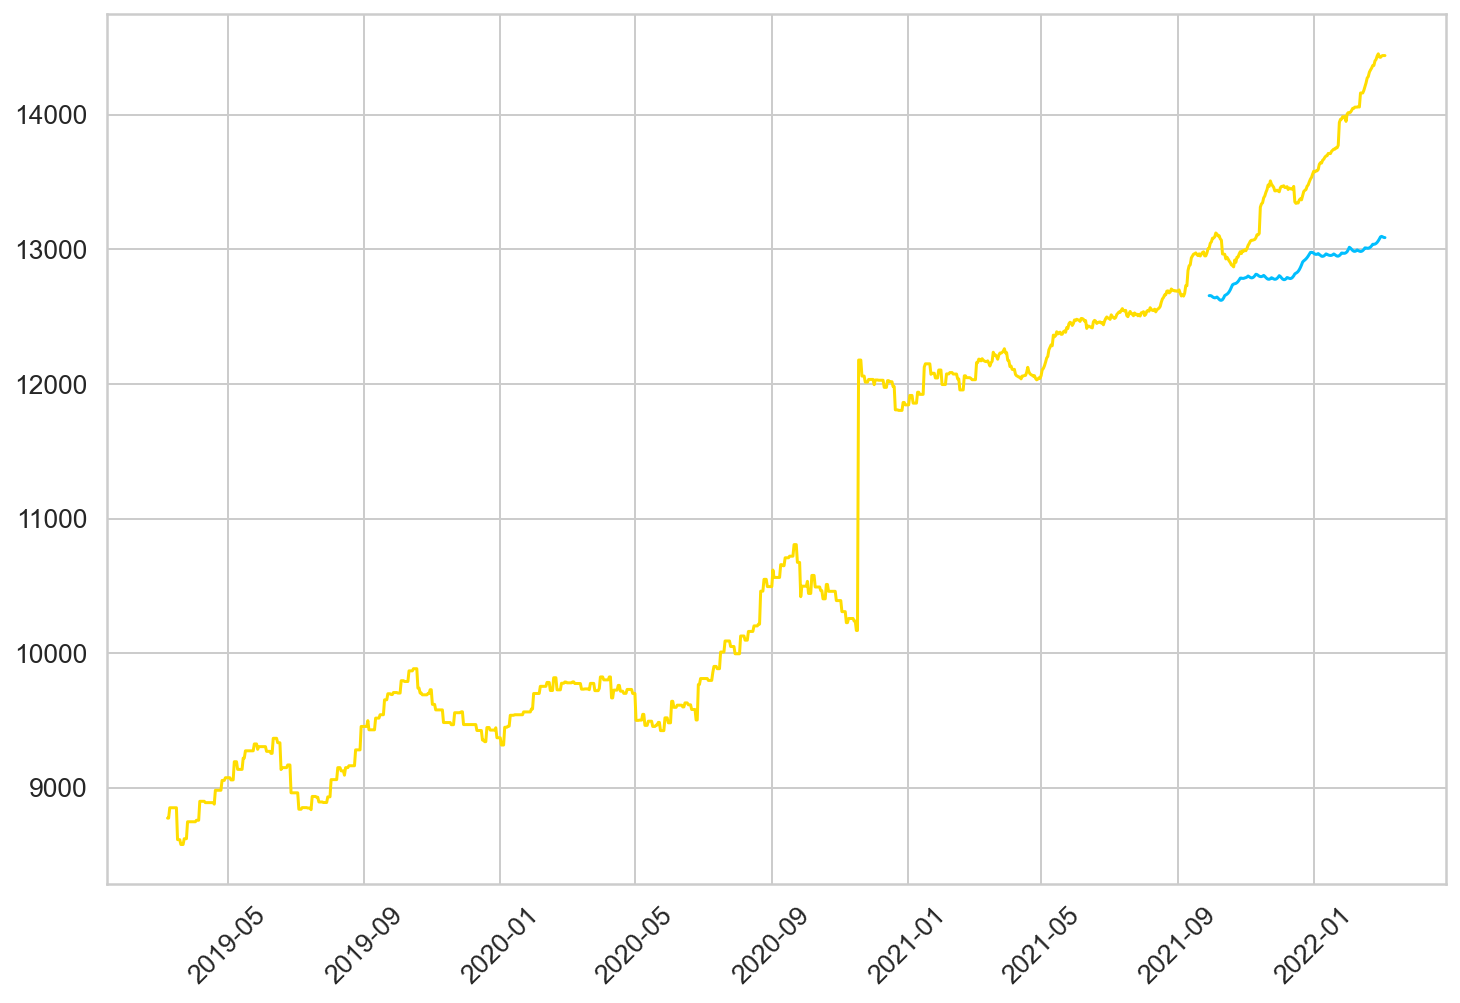

In [46]:
test_dates = matplotlib.dates.date2num(test_sequences_data.Date.tolist())
all_dates = matplotlib.dates.date2num(watch.Date.tolist())
plt.plot_date(test_dates[DAYS_PREDICTION:], predictions_descaled, '-', label='predicted')
plt.plot_date(all_dates, watch.Price.tolist(), '-', label='real')

# i = 185
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_1')

# i = 250
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_2')

# i = 620
# plt.plot_date([test_dates[i-SEQUENCE_LENGTH], test_dates[i], test_dates[DAYS_PREDICTION+i]], 
# [labels_descaled[i-DAYS_PREDICTION-SEQUENCE_LENGTH], labels_descaled[i-DAYS_PREDICTION], predictions_descaled[i]], '-', label='PREDICTION_3')

plt.xticks(rotation=45)
# plt.legend()
plt.show()

# Evalution function

In [47]:
# class prediction:
#     def __init__(self, model_path, n_features):
#         self.trained_model = PricePredictor.load_from_checkpoint(
#             model_path,
#             n_features=n_features
#         )
#         self.trained_model.freeze()

#     def get_result(self, sequence, days):
#         _, predictions = trained_model(sequence.unsqueeze(dim=0))
        


In [48]:
df = pd.DataFrame()
df['min'] = scaler.min_
df['scale'] = scaler.scale_
df.to_csv('checkpoints/scale.csv')
df.head()

,min,scale
0,-1.000000,0.333333
1,-1.066667,0.066667
2,-1.038462,0.038462
3,-1.181818,0.181818
4,-0.774735,0.000883


In [49]:
err = (np.abs(predictions_descaled-labels_descaled)/labels_descaled*100)


In [50]:
err

array([2.71162604, 2.97456169, 3.07445603, 3.32611151, 3.37482336,
       3.45891822, 3.66263794, 3.56623229, 3.52451717, 3.6127776 ,
       3.48324114, 3.42240112, 2.61614411, 2.51487386, 2.37064985,
       2.0628143 , 2.12371418, 1.96700423, 1.76755905, 1.56365686,
       1.29826705, 1.10956855, 0.99191117, 1.36585775, 1.21270588,
       1.45975682, 1.39990361, 1.49342746, 1.51215739, 1.40512739,
       1.5808405 , 1.54987871, 1.60706966, 1.5376285 , 1.63138338,
       1.74671519, 1.89097222, 2.06552629, 2.13962399, 2.13029088,
       2.11255781, 2.06624385, 2.0676511 , 2.25640446, 2.29823203,
       2.41582129, 3.87562825, 4.05026077, 4.08379746, 4.30409451,
       4.45640172, 4.71781456, 4.9163175 , 5.19604606, 5.12268397,
       5.38091218, 5.15675375, 5.10149069, 5.05618744, 4.89088048,
       4.88065784, 4.87795765, 4.76996799, 4.64122613, 4.89947821,
       5.0444014 , 5.1088922 , 5.17871918, 5.08414536, 5.04323554,
       5.01241755, 4.88259945, 4.98915339, 4.96358717, 4.92296

In [51]:
print(len(test_dates[DAYS_PREDICTION:]))
print(len(predictions_descaled))

159
159


In [52]:
date_list = test_sequences_data.Date.tolist()
err_df = pd.DataFrame()
err_df["Date"] = date_list[DAYS_PREDICTION:]
err_df["%Error"] = err
err_df.head()

,Date,%Error
0,2021-09-29,2.711626
1,2021-09-30,2.974562
2,2021-10-01,3.074456
3,2021-10-02,3.326112
4,2021-10-03,3.374823


In [53]:
def Load_data(path):
    # Load watch price
    watch = pd.read_csv(path)
    watch['Date'] = pd.to_datetime(watch['Date'], dayfirst=True)
    watch['Price'] = pd.to_numeric(watch['Price'])
    watch = watch.resample('D', on='Date', convention='s').mean()
    watch['Date'] = watch.index
    watch.reset_index(drop=True, inplace=True)
    watch.fillna(method='ffill', inplace=True)
    watch["Prev_Price"] = watch.shift(1)["Price"]
    watch["Price_Change"] = watch.progress_apply(
        lambda row: 0 if np.isnan(row["Prev_Price"]) else row["Price"] - row["Prev_Price"],
        axis = 1
    )
    # Creat watch feature
    rows = []
    for _, row in tqdm(watch.iterrows(), total=watch.shape[0]):
        row_data = dict(
            day_of_week = row.Date.dayofweek,
            day_of_month = row.Date.day,
            week_of_year = row.Date.week,
            month = row.Date.month,
            price_change = row.Price_Change,
            price = row.Price
        )
        rows.append(row_data)
    return pd.DataFrame(rows)


In [79]:
def create_pred_sequences(input_data: pd.DataFrame, target_column, sequence_length):
    sequences = []
    sequence = input_data[-sequence_length:]
    label = input_data.iloc[-1][target_column]
    sequences.append((sequence, label))
    return sequences

In [88]:
def prediction(
        path, 
        model_name,
        scaler,
        train_n_features,
        SEQUENCE_LENGTH = 30
    ):
    features_df = Load_data(path)
    features_df = pd.DataFrame(
        scaler.transform(features_df),
        index=features_df.index,
        columns=features_df.columns
    )
    pred_sequences = create_pred_sequences(features_df, "price", SEQUENCE_LENGTH)
    pred_dataset = TS_Dataset(pred_sequences)

    trained_model = PricePredictor.load_from_checkpoint(
        "checkpoints/"+model_name+".ckpt",
        n_features=train_n_features
    )
    trained_model.freeze()

    predictions = []
    for item in tqdm(pred_dataset):
        sequence = item['sequence']
        _, output = trained_model(sequence.unsqueeze(dim=0))
        predictions.append(output.item())

    descaler = MinMaxScaler()
    descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

    predictions_descaled = descale(descaler, predictions)
    print("prediction Next 1M:", round(predictions_descaled[0], 2))

In [89]:
prediction(
        path, 
        "best-checkpoint",
        scaler,
        train_df.shape[1]
    )

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

prediction Next 1M: 13243.47


In [112]:
col = ["Model", "Current Price", 
"Growth 1M", "Growth 3M",
"Predition 1M", "Predition 3M"]
df = pd.DataFrame([["Rolex", 0, 0, 0, 0, 0]], columns=col)
Model_Price_df = pd.DataFrame(columns=col)
for i in range(5):
    df = pd.DataFrame([["Rolex", i, i+1, i*2, i+5, i/2]], columns=col)
    Model_Price_df = pd.concat([Model_Price_df, df])
Model_Price_df.head()

,Model,Current Price,Growth 1M,Growth 3M,Predition 1M,Predition 3M
0,Rolex,0,1,0,5,0.0
0,Rolex,1,2,2,6,0.5
0,Rolex,2,3,4,7,1.0
0,Rolex,3,4,6,8,1.5
0,Rolex,4,5,8,9,2.0


In [113]:
features_df = Load_data(path)
features_df[-5:].head()

  0%|          | 0/1095 [00:00<?, ?it/s]

  0%|          | 0/1095 [00:00<?, ?it/s]

,day_of_week,day_of_month,week_of_year,month,price_change,price
1090,2,2,9,3,-2.0,14427.0
1091,3,3,9,3,10.0,14437.0
1092,4,4,9,3,3.0,14440.0
1093,5,5,9,3,0.0,14440.0
1094,6,6,9,3,0.0,14440.0


In [116]:
(features_df.price).iloc[-30]

14440.0